# Jailbreak Detect

## Session setup

In [1]:
!export CUDA_LAUNCH_BLOCKING=1

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir("/mnt/home/amir/framingdecomp/framingDecomp")

import sys
sys.path.append(os.getcwd())

In [2]:
# Check to make sure there are multiple gpus available
import torch, os
print("Devices visible:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("torch.cud:a.device_count():", torch.cuda.device_count())

# os.environ["CUDA_VISIBLE_DEVICES"] = "6"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cuda" if torch.cuda.is_available() else "cpu"


Devices visible: 7
torch.cud:a.device_count(): 1


In [3]:
os.environ.get("CUDA_VISIBLE_DEVICES")

'7'

In [4]:
os.getcwd()

'/mnt/home/amir/framingdecomp/framingDecomp'

In [5]:
# ==== Cell: [Session setup] ====

import os
import sys
import logging
import yaml
import json
import uuid
import time
import pickle
import random
from pathlib import Path
from datetime import datetime

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

from accelerate import notebook_launcher
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from scipy.stats import chi2
import matplotlib.pyplot as plt

from utils.misc import set_seed
from utils.model_utils import load_model
from models.encoder import HFEncoder_notPooled
from models.decomposer import NonlinearDecomposer, NonlinearDecomposer_tiny

# ——— Configuration switches ———
USE_MULTIGPU       = False
VISIBLE_DEVICES    = os.environ.get("CUDA_VISIBLE_DEVICES")#"0,1,2,3,4,5,6,7"
MIXED_PRECISION    = "fp16"
DETECT_VIA_FRAMING = True

# ——— GPU setup ———
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
if USE_MULTIGPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = VISIBLE_DEVICES

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}, GPUs available: {torch.cuda.device_count()}")

# ——— Paths & IDs ———
CFG_PATH    = "configs/jb_detect.yaml"
# UNIQUE_ID = "20250719_232328_fc7e001b-2263-4f0d-a7e3-7a614ea80326" # all layers llama 2
# UNIQUE_ID = "20250721_204859_8666ba39-8c81-4293-8a3f-714efcc5f6f9" # all layers vicuna 7b
# UNIQUE_ID = "20250722_025458_074a110c-2578-4143-87f1-763b1c892868" # all layers Llama 3 8b
UNIQUE_ID = "20250722_171500_d895e0d2-babf-4915-b4f4-79de5c156b86" # all layers vicuna 13b
# UNIQUE_ID = "20250722_164739_1a86b97e-6703-4060-8cc0-21ed0a7bc089" # all layers Mistral 7b

DECOMP_CKPT = Path(f"./checkpoints/decomposer_simple/decomposer_{UNIQUE_ID}")

cfg_unique_id = UNIQUE_ID
# cfg_unique_id = "20250719_003746_3355037c-77e8-4595-85e9-7b1fd94e8bff" # llama 2
# cfg_unique_id = "20250721_204859_8666ba39-8c81-4293-8a3f-714efcc5f6f9" # vicuna 7b
# cfg_unique_id = "20250722_025458_074a110c-2578-4143-87f1-763b1c892868" # all layers Llama 3 8b
cfg_unique_id = "vic13_20250722_171500_d895e0d2-babf-4915-b4f4-79de5c156b86" # all layers vicuna 13b
# cfg_unique_id = "20250722_164739_1a86b97e-6703-4060-8cc0-21ed0a7bc089" # all layers Mistral 7b
CFG_OUT     = Path(f"output/config_{cfg_unique_id}.yaml")

# ——— Load configs ———
with open(CFG_OUT, 'r') as f:
    cfg_out = yaml.safe_load(f)
with open(CFG_PATH, 'r') as f:
    config = yaml.safe_load(f)

# override any layer settings from the output config
config['model']['layers']         = cfg_out['model'].get('layers', 'last')
config['model']['layer_combine']  = cfg_out['model'].get('layer_combine', 'mean')
config['d_g'] = cfg_out['d_g']
config['d_f'] = cfg_out['d_f']
# config['hidden_dim'] = cfg_out['hidden_dim']
ENC_LLM_NAME = cfg_out['model']['name']

# ——— Logging & seeds ———
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s — %(name)s — %(levelname)s — %(message)s'
)
logger = logging.getLogger(__name__)

seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
set_seed(seed)

logger.info("Session setup complete.")


INFO:__main__:Session setup complete.


Device: cuda, GPUs available: 1


## Load Data

### Split again and reorganize by cats

In [ ]:
# # ==== Cell: [Data Loading & Preprocessing] ====

# def load_jsonl(path: str):
#     with open(path, 'r') as f:
#         return [
#             json.loads(line)
#             for line in f
#             if line.strip() and not line.strip().startswith('#')
#         ]

# # paths from config
# data_cfg = config['data']
# rawF_id            = load_jsonl(data_cfg["input_path_varyFraming_id"])
# rawG_id            = load_jsonl(data_cfg["input_path_varyGoal_id"])
# rawF_benign_id     = load_jsonl(data_cfg["input_path_varyFraming_benign_id"])
# rawG_benign_id     = load_jsonl(data_cfg["input_path_varyGoal_benign_id"])
# rawF_ood           = load_jsonl(data_cfg["input_path_varyFraming_ood"])
# rawG_ood           = load_jsonl(data_cfg["input_path_varyGoal_ood"])
# rawF_benign_ood    = load_jsonl(data_cfg["input_path_varyFraming_benign_ood"])
# rawG_benign_ood    = load_jsonl(data_cfg["input_path_varyGoal_benign_ood"])


# all_F_benign   = rawF_benign_id + rawF_benign_ood
# all_G_benign   = rawG_benign_id + rawG_benign_ood
# all_F_jailbrks = rawF_id        + rawF_ood
# all_G_jailbrks = rawG_id        + rawG_ood

# categories_F_benign = set([x['category'] for x in all_F_benign])
# categories_G_benign = set([x['category'] for x in all_G_benign])
# categories_F_jailbrks = set([x['category'] for x in all_F_jailbrks])
# categories_G_jailbrks = set([x['category'] for x in all_G_jailbrks])
# intersection = categories_F_benign.intersection(categories_G_benign)
# intersection = intersection.intersection(categories_F_jailbrks)
# intersection = intersection.intersection(categories_G_jailbrks)
# import random
# random.seed(seed)
# ood_cats = set(random.sample(list(intersection), len(intersection) // 3))
# id_cats = intersection.difference(ood_cats)


# rawF_id            = [entry for entry in rawF_id
#                       if entry['category'] in id_cats]
# rawG_id            = [entry for entry in rawG_id
#                       if entry['category'] in id_cats]
# rawF_benign_id     = [entry for entry in rawF_benign_id
#                             if entry['category'] in id_cats]
# rawG_benign_id     = [entry for entry in rawG_benign_id
#                       if entry['category'] in id_cats]
# rawF_ood           = [entry for entry in rawF_ood
#                       if entry['category'] in ood_cats]
# rawG_ood           = [entry for entry in rawG_ood
#                       if entry['category'] in ood_cats]
# rawF_benign_ood    = [entry for entry in rawF_benign_ood
#                             if entry['category'] in ood_cats]
# rawG_benign_ood    = [entry for entry in rawG_benign_ood
#                       if entry['category'] in ood_cats]

In [42]:
# combine and flag
benign_id    = rawF_benign_id + rawG_benign_id
jailbrks_id  = rawF_id          + rawG_id
benign_ood   = rawF_benign_ood  + rawG_benign_ood
jailbrks_ood = rawF_ood         + rawG_ood

print(f"{len(benign_id)=}, {len(jailbrks_id)=}")
print(f"{len(benign_ood)=}, {len(jailbrks_ood)=}")

# balance ID splits
min_id = min(len(benign_id), len(jailbrks_id))
benign_id   = random.sample(benign_id, min_id)
jailbrks_id = random.sample(jailbrks_id, min_id)

# extract raw prompts
get_prompts = lambda items: [e["prompt"] for e in items]
ben_ID   = get_prompts(benign_id)
jb_ID    = get_prompts(jailbrks_id)
ben_OOD  = get_prompts(benign_ood)
jb_OOD   = get_prompts(jailbrks_ood)


len(benign_id)=1778, len(jailbrks_id)=1743
len(benign_ood)=192, len(jailbrks_ood)=167


#### Load the original PAIR data

In [ ]:
# import os
# import json
# from pathlib import Path

# def load_all_pair_prompts(black_box_dir="./data/artifacts/attack-artifacts/PAIR/black_box/"):
#     prompts = []
#     for file in Path(black_box_dir).glob("*.json"):
#         with open(file, "r") as f:
#             data = json.load(f)
#             for jb in data.get("jailbreaks", []):
#                 if jb.get("prompt") is not None:
#                     prompts.append(jb["prompt"])
#     return prompts

# all_pair_prompts = load_all_pair_prompts()
# jb_ID = all_pair_prompts
# jb_OOD = all_pair_prompts

### Keep the same splits

In [6]:
# ==== Cell: [Data Loading & Preprocessing] ====

def load_jsonl(path: str):
    with open(path, 'r') as f:
        return [
            json.loads(line)
            for line in f
            if line.strip() and not line.strip().startswith('#')
        ]

# paths from config
data_cfg = config['data']
rawF_id            = load_jsonl(data_cfg["input_path_varyFraming_id"])
rawG_id            = load_jsonl(data_cfg["input_path_varyGoal_id"])
rawF_benign_id     = load_jsonl(data_cfg["input_path_varyFraming_benign_id"])
rawG_benign_id     = load_jsonl(data_cfg["input_path_varyGoal_benign_id"])
rawF_ood           = load_jsonl(data_cfg["input_path_varyFraming_ood"])
rawG_ood           = load_jsonl(data_cfg["input_path_varyGoal_ood"])
rawF_benign_ood    = load_jsonl(data_cfg["input_path_varyFraming_benign_ood"])
rawG_benign_ood    = load_jsonl(data_cfg["input_path_varyGoal_benign_ood"])

# combine and flag
benign_id    = rawF_benign_id + rawG_benign_id
jailbrks_id  = rawF_id          + rawG_id
benign_ood   = rawF_benign_ood  + rawG_benign_ood
jailbrks_ood = rawF_ood         + rawG_ood

print(f"{len(benign_id)=}, {len(jailbrks_id)=}")
print(f"{len(benign_ood)=}, {len(jailbrks_ood)=}")

# balance ID splits
min_id = min(len(benign_id), len(jailbrks_id))
benign_id   = random.sample(benign_id, min_id)
jailbrks_id = random.sample(jailbrks_id, min_id)

# extract raw prompts
get_prompts = lambda items: [e["prompt"] for e in items]
ben_ID   = get_prompts(benign_id)
jb_ID    = get_prompts(jailbrks_id)
ben_OOD  = get_prompts(benign_ood)
jb_OOD   = get_prompts(jailbrks_ood)



len(benign_id)=2562, len(jailbrks_id)=2724
len(benign_ood)=672, len(jailbrks_ood)=705


## Load Model

In [7]:
# # ==== Cell: [Model & Decomposer Initialization] ====

# load LLM encoder
model_llm, tokenizer = load_model(ENC_LLM_NAME, device=device)
encoder = HFEncoder_notPooled(
    model=model_llm,
    tokenizer=tokenizer,
    device=device,
    layers="last",#config['model']['layers'],
    layer_combine=config['model']['layer_combine'],
)

# # load decomposer weights
# ckpt = torch.load(DECOMP_CKPT / "weights.pt", map_location=device)
# enc_dim_ckpt = ckpt["Wg.0.weight"].shape[1]

# decomposer = NonlinearDecomposer(
#     enc_dim    = enc_dim_ckpt,
#     d_g        = config['d_g'],
#     d_f        = config['d_f'],
#     hidden_dim = config.get('hidden_dim', 1024),
#     dropout    = config.get('dropout', 0.1),
# ).to(device)
# # decomposer = NonlinearDecomposer_tiny(
# #     enc_dim    = enc_dim_ckpt,
# # ).to(device)

# decomposer.load_state_dict(ckpt)
# decomposer.half().eval()
# decomposer.eval()
# encoder.eval()

# logger.info(f"Loaded encoder + decomposer (enc_dim={enc_dim_ckpt}).")


INFO:utils.model_utils:Loading model: lmsys/vicuna-13b-v1.5 on cuda
/mnt/home/amir/jupyter-env/lib/python3.11/site-packages/transformers/models/auto/tokenization_auto.py:902: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/mnt/home/amir/jupyter-env/lib/python3.11/site-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


#### Find critical layer - nsp dist

In [8]:
# RUN_ID_dec = "20250719" # UNIQUE_ID # for llama2 only
RUN_ID_dec = UNIQUE_ID # for llama2 only
import re, glob, os

pattern = re.compile(r"decomposer_layer(\d+)_")
ckpt_by_layer = {}
# for p in glob.glob(f"./checkpoints/decomposer_simple/decomposer_layer*{RUN_ID_dec}*"):
for p in glob.glob(f"./checkpoints/decomposer_simple/vic13_decomposer_layer*{RUN_ID_dec}*"): # for vicuna 13b only
    m = pattern.search(os.path.basename(p))
    if m: ckpt_by_layer[int(m.group(1))] = p

In [9]:
N_CAL = 200              # or leave tunable in YAML
cal_benign   = random.sample(ben_ID,    N_CAL//2)
cal_jailbreak= random.sample(jb_ID,  N_CAL//2)

from utils.critial_layer import find_critical_layers, find_critical_layers_dist

layers = 'all'#config["model"]["layers"]
if layers == 'all':
    num_layers = model_llm.config.num_hidden_layers
    layers = list(range(num_layers))

cl_outs = dict()
best_g, best_f = dict(), dict()
for layer in layers:
    # ==== Cell: [Model & Decomposer Initialization] ====

    # load decomposer weights
    ckpt = torch.load(f"{ckpt_by_layer[layer]}/weights.pt", map_location=device)
    enc_dim_ckpt = ckpt["Wg.0.weight"].shape[1]

    decomposer = NonlinearDecomposer(
        enc_dim    = enc_dim_ckpt,
        d_g        = config['d_g'],
        d_f        = config['d_f'],
        hidden_dim = config.get('hidden_dim', 1024),
        dropout    = config.get('dropout', 0.1),
    ).to(device)

    decomposer.load_state_dict(ckpt)
    decomposer.half().eval()
    decomposer.eval()
    
    # logger.info(f"Loaded encoder + decomposer (enc_dim={enc_dim_ckpt}).")
    print(f"\n\n\nlayer {layer}:\n")
    with torch.no_grad():
        cl_outs[layer] = find_critical_layers_dist(HFEncoder_notPooled, model_llm, tokenizer, device, 
                                                decomposer, cal_benign, cal_jailbreak, [layer],
                                                criterion='cohen_d')
        best_g[layer] = {"encoder_l": cl_outs[layer]["best_layer_goal"], "score": cl_outs[layer]["score_goal"]}
        best_f[layer] = {"encoder_l": cl_outs[layer]["best_layer_framing"], "score": cl_outs[layer]["score_framing"]}
        print(f"Best G: {best_g[layer]}, Best F: {best_f[layer]}")






layer 0:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]


layer  0:   framing=1.9976 , goal=2.5273
Best G: {'encoder_l': 0, 'score': np.float64(2.5273423966078457)}, Best F: {'encoder_l': 0, 'score': np.float64(1.9975943890248253)}



layer 1:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.28s/it]


layer  1:   framing=6.3706 , goal=5.7617
Best G: {'encoder_l': 1, 'score': np.float64(5.761684851224236)}, Best F: {'encoder_l': 1, 'score': np.float64(6.370583256595125)}



layer 2:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.29s/it]


layer  2:   framing=7.1428 , goal=6.0072
Best G: {'encoder_l': 2, 'score': np.float64(6.007231602901001)}, Best F: {'encoder_l': 2, 'score': np.float64(7.1428095201266295)}



layer 3:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]


layer  3:   framing=8.1389 , goal=6.6082
Best G: {'encoder_l': 3, 'score': np.float64(6.608168451022776)}, Best F: {'encoder_l': 3, 'score': np.float64(8.138891393104446)}



layer 4:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.29s/it]


layer  4:   framing=6.5323 , goal=6.2503
Best G: {'encoder_l': 4, 'score': np.float64(6.2502800525968665)}, Best F: {'encoder_l': 4, 'score': np.float64(6.532277720822208)}



layer 5:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


layer  5:   framing=5.3052 , goal=5.6883
Best G: {'encoder_l': 5, 'score': np.float64(5.6883162694940985)}, Best F: {'encoder_l': 5, 'score': np.float64(5.305227021877235)}



layer 6:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


layer  6:   framing=5.2965 , goal=5.8087
Best G: {'encoder_l': 6, 'score': np.float64(5.808739079942538)}, Best F: {'encoder_l': 6, 'score': np.float64(5.296453330947226)}



layer 7:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


layer  7:   framing=5.5928 , goal=5.4950
Best G: {'encoder_l': 7, 'score': np.float64(5.494983959391104)}, Best F: {'encoder_l': 7, 'score': np.float64(5.592782978220041)}



layer 8:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


layer  8:   framing=5.7589 , goal=5.3445
Best G: {'encoder_l': 8, 'score': np.float64(5.344526047098769)}, Best F: {'encoder_l': 8, 'score': np.float64(5.758939438333123)}



layer 9:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.29s/it]


layer  9:   framing=6.3387 , goal=5.1681
Best G: {'encoder_l': 9, 'score': np.float64(5.168050448922689)}, Best F: {'encoder_l': 9, 'score': np.float64(6.338684822657897)}



layer 10:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/it]


layer 10:   framing=7.1624 , goal=5.3436
Best G: {'encoder_l': 10, 'score': np.float64(5.34361037740408)}, Best F: {'encoder_l': 10, 'score': np.float64(7.162365139164139)}



layer 11:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


layer 11:   framing=6.4171 , goal=4.6460
Best G: {'encoder_l': 11, 'score': np.float64(4.64602007954663)}, Best F: {'encoder_l': 11, 'score': np.float64(6.417083931432585)}



layer 12:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


layer 12:   framing=8.5848 , goal=4.5585
Best G: {'encoder_l': 12, 'score': np.float64(4.558480224143569)}, Best F: {'encoder_l': 12, 'score': np.float64(8.584770052396378)}



layer 13:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.29s/it]


layer 13:   framing=7.7814 , goal=3.9781
Best G: {'encoder_l': 13, 'score': np.float64(3.978089898891533)}, Best F: {'encoder_l': 13, 'score': np.float64(7.781373625698689)}



layer 14:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.17s/it]


layer 14:   framing=8.7971 , goal=5.1094
Best G: {'encoder_l': 14, 'score': np.float64(5.109377850092858)}, Best F: {'encoder_l': 14, 'score': np.float64(8.797057915532655)}



layer 15:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


layer 15:   framing=8.1994 , goal=4.9082
Best G: {'encoder_l': 15, 'score': np.float64(4.908249234107173)}, Best F: {'encoder_l': 15, 'score': np.float64(8.199388646937935)}



layer 16:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


layer 16:   framing=8.9589 , goal=5.1385
Best G: {'encoder_l': 16, 'score': np.float64(5.138455951917531)}, Best F: {'encoder_l': 16, 'score': np.float64(8.95886791127011)}



layer 17:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]


layer 17:   framing=9.6740 , goal=4.1123
Best G: {'encoder_l': 17, 'score': np.float64(4.11226702858375)}, Best F: {'encoder_l': 17, 'score': np.float64(9.67396200652483)}



layer 18:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


layer 18:   framing=9.3009 , goal=4.6134
Best G: {'encoder_l': 18, 'score': np.float64(4.61336754089305)}, Best F: {'encoder_l': 18, 'score': np.float64(9.300907608936857)}



layer 19:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.86s/it]


layer 19:   framing=8.7936 , goal=4.0653
Best G: {'encoder_l': 19, 'score': np.float64(4.065337006751308)}, Best F: {'encoder_l': 19, 'score': np.float64(8.793609551390126)}



layer 20:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


layer 20:   framing=8.8121 , goal=4.6114
Best G: {'encoder_l': 20, 'score': np.float64(4.611436322974303)}, Best F: {'encoder_l': 20, 'score': np.float64(8.812104096506749)}



layer 21:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/it]


layer 21:   framing=8.4729 , goal=4.4344
Best G: {'encoder_l': 21, 'score': np.float64(4.434395165057689)}, Best F: {'encoder_l': 21, 'score': np.float64(8.472942064809132)}



layer 22:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.29s/it]


layer 22:   framing=8.6753 , goal=3.9094
Best G: {'encoder_l': 22, 'score': np.float64(3.9094315400554387)}, Best F: {'encoder_l': 22, 'score': np.float64(8.675289142300706)}



layer 23:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.14s/it]


layer 23:   framing=8.5655 , goal=3.8244
Best G: {'encoder_l': 23, 'score': np.float64(3.8244329783790465)}, Best F: {'encoder_l': 23, 'score': np.float64(8.565526193586699)}



layer 24:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


layer 24:   framing=6.9276 , goal=4.0389
Best G: {'encoder_l': 24, 'score': np.float64(4.038910397904468)}, Best F: {'encoder_l': 24, 'score': np.float64(6.927566420550147)}



layer 25:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.24s/it]


layer 25:   framing=5.8596 , goal=3.7801
Best G: {'encoder_l': 25, 'score': np.float64(3.780130073768209)}, Best F: {'encoder_l': 25, 'score': np.float64(5.859642837301982)}



layer 26:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.33s/it]


layer 26:   framing=4.8046 , goal=3.7926
Best G: {'encoder_l': 26, 'score': np.float64(3.792577989819254)}, Best F: {'encoder_l': 26, 'score': np.float64(4.80456772336025)}



layer 27:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


layer 27:   framing=5.5186 , goal=3.5939
Best G: {'encoder_l': 27, 'score': np.float64(3.593904079057346)}, Best F: {'encoder_l': 27, 'score': np.float64(5.5185849524163375)}



layer 28:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/it]


layer 28:   framing=4.8813 , goal=3.4730
Best G: {'encoder_l': 28, 'score': np.float64(3.472973073340153)}, Best F: {'encoder_l': 28, 'score': np.float64(4.881288950259964)}



layer 29:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]


layer 29:   framing=5.6446 , goal=3.5067
Best G: {'encoder_l': 29, 'score': np.float64(3.5067270352801945)}, Best F: {'encoder_l': 29, 'score': np.float64(5.644638932386899)}



layer 30:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


layer 30:   framing=5.3546 , goal=3.3851
Best G: {'encoder_l': 30, 'score': np.float64(3.385052819269075)}, Best F: {'encoder_l': 30, 'score': np.float64(5.354578487781947)}



layer 31:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


layer 31:   framing=5.4019 , goal=3.4855
Best G: {'encoder_l': 31, 'score': np.float64(3.485536312407987)}, Best F: {'encoder_l': 31, 'score': np.float64(5.401915928402939)}



layer 32:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


layer 32:   framing=4.5155 , goal=3.6588
Best G: {'encoder_l': 32, 'score': np.float64(3.658792492246247)}, Best F: {'encoder_l': 32, 'score': np.float64(4.515451154961106)}



layer 33:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


layer 33:   framing=4.6890 , goal=3.4259
Best G: {'encoder_l': 33, 'score': np.float64(3.4259492675281096)}, Best F: {'encoder_l': 33, 'score': np.float64(4.689000537887338)}



layer 34:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


layer 34:   framing=5.4334 , goal=3.4756
Best G: {'encoder_l': 34, 'score': np.float64(3.4755984573684406)}, Best F: {'encoder_l': 34, 'score': np.float64(5.4333794672587725)}



layer 35:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


layer 35:   framing=4.7563 , goal=3.1414
Best G: {'encoder_l': 35, 'score': np.float64(3.141367468628525)}, Best F: {'encoder_l': 35, 'score': np.float64(4.756328840955035)}



layer 36:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.28s/it]


layer 36:   framing=4.0850 , goal=3.1012
Best G: {'encoder_l': 36, 'score': np.float64(3.1011836110731057)}, Best F: {'encoder_l': 36, 'score': np.float64(4.084956000544779)}



layer 37:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.88s/it]


layer 37:   framing=4.1352 , goal=3.0135
Best G: {'encoder_l': 37, 'score': np.float64(3.0134902208497674)}, Best F: {'encoder_l': 37, 'score': np.float64(4.135165814692627)}



layer 38:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.21s/it]


layer 38:   framing=3.8076 , goal=2.5369
Best G: {'encoder_l': 38, 'score': np.float64(2.5368641681538624)}, Best F: {'encoder_l': 38, 'score': np.float64(3.8076459416621824)}



layer 39:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]

layer 39:   framing=2.7478 , goal=2.5116
Best G: {'encoder_l': 39, 'score': np.float64(2.5115880768406518)}, Best F: {'encoder_l': 39, 'score': np.float64(2.7478119405947345)}


#### Find critical layer - cosine

In [ ]:
# RUN_ID_dec = "20250719" # UNIQUE_ID # for llama2 only
import re, glob, os

pattern = re.compile(r"decomposer_layer(\d+)_")
ckpt_by_layer = {}
for p in glob.glob(f"./checkpoints/decomposer_simple/decomposer_layer*{RUN_ID_dec}*"):
# for p in glob.glob(f"./checkpoints/decomposer_simple/vic13_decomposer_layer*{RUN_ID_dec}*"): # for vicuna 13b only
    m = pattern.search(os.path.basename(p))
    if m: ckpt_by_layer[int(m.group(1))] = p

In [72]:
N_CAL = 100              # or leave tunable in YAML
cal_benign   = random.sample(ben_ID,    N_CAL//2)
cal_jailbreak= random.sample(jb_ID,  N_CAL//2)

from utils.critial_layer import find_critical_layers

layers = 'all'#config["model"]["layers"]
if layers == 'all':
    num_layers = model_llm.config.num_hidden_layers
    layers = list(range(num_layers))

cl_outs = dict()
best_g_cos, best_f_cos = dict(), dict()
for layer in layers:
    # ==== Cell: [Model & Decomposer Initialization] ====

    # load decomposer weights
    ckpt = torch.load(f"{ckpt_by_layer[layer]}/weights.pt", map_location=device)
    enc_dim_ckpt = ckpt["Wg.0.weight"].shape[1]

    decomposer = NonlinearDecomposer(
        enc_dim    = enc_dim_ckpt,
        d_g        = config['d_g'],
        d_f        = config['d_f'],
        hidden_dim = config.get('hidden_dim', 1024),
        dropout    = config.get('dropout', 0.1),
    ).to(device)
    # decomposer = NonlinearDecomposer_tiny(
    #     enc_dim    = enc_dim_ckpt,
    # ).to(device)

    decomposer.load_state_dict(ckpt)
    decomposer.half().eval()
    decomposer.eval()
    # encoder.eval()

    # logger.info(f"Loaded encoder + decomposer (enc_dim={enc_dim_ckpt}).")
    print(f"\n\n\nlayer {layer}:\n")
    with torch.no_grad():
        cl_outs[layer] = find_critical_layers(HFEncoder_notPooled, model_llm, tokenizer, device, 
                                                decomposer, cal_benign, cal_jailbreak, [layer])
        best_g_cos[layer] = {"encoder_l": cl_outs[layer]["l_g"], "Δ": cl_outs[layer]["Δ_g"]}
        best_f_cos[layer] = {"encoder_l": cl_outs[layer]["l_f"], "Δ": cl_outs[layer]["Δ_f"]}
        print(f"Best G: {best_g_cos[layer]}, Best F: {best_f_cos[layer]}")






layer 0:



  0%|                                                                                                                                                              | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


layer 0: Δ_f: 1.38623046875, Δ_g: 0.56494140625
Best G: {'encoder_l': 0, 'Δ': 0.56494140625}, Best F: {'encoder_l': 0, 'Δ': 1.38623046875}



layer 1:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 1: Δ_f: 1.39892578125, Δ_g: 0.695556640625
Best G: {'encoder_l': 1, 'Δ': 0.695556640625}, Best F: {'encoder_l': 1, 'Δ': 1.39892578125}



layer 2:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 2: Δ_f: 1.34814453125, Δ_g: 0.760986328125
Best G: {'encoder_l': 2, 'Δ': 0.760986328125}, Best F: {'encoder_l': 2, 'Δ': 1.34814453125}



layer 3:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 3: Δ_f: 1.3671875, Δ_g: 0.645263671875
Best G: {'encoder_l': 3, 'Δ': 0.645263671875}, Best F: {'encoder_l': 3, 'Δ': 1.3671875}



layer 4:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 4: Δ_f: 1.3671875, Δ_g: 1.286376953125
Best G: {'encoder_l': 4, 'Δ': 1.286376953125}, Best F: {'encoder_l': 4, 'Δ': 1.3671875}



layer 5:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 5: Δ_f: 1.36279296875, Δ_g: 0.964111328125
Best G: {'encoder_l': 5, 'Δ': 0.964111328125}, Best F: {'encoder_l': 5, 'Δ': 1.36279296875}



layer 6:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 6: Δ_f: 1.364990234375, Δ_g: 0.8233642578125
Best G: {'encoder_l': 6, 'Δ': 0.8233642578125}, Best F: {'encoder_l': 6, 'Δ': 1.364990234375}



layer 7:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 7: Δ_f: 1.326171875, Δ_g: 0.83837890625
Best G: {'encoder_l': 7, 'Δ': 0.83837890625}, Best F: {'encoder_l': 7, 'Δ': 1.326171875}



layer 8:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 8: Δ_f: 1.35986328125, Δ_g: 0.79345703125
Best G: {'encoder_l': 8, 'Δ': 0.79345703125}, Best F: {'encoder_l': 8, 'Δ': 1.35986328125}



layer 9:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 9: Δ_f: 1.357666015625, Δ_g: 0.87896728515625
Best G: {'encoder_l': 9, 'Δ': 0.87896728515625}, Best F: {'encoder_l': 9, 'Δ': 1.357666015625}



layer 10:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 10: Δ_f: 1.341796875, Δ_g: 0.88372802734375
Best G: {'encoder_l': 10, 'Δ': 0.88372802734375}, Best F: {'encoder_l': 10, 'Δ': 1.341796875}



layer 11:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 11: Δ_f: 1.358642578125, Δ_g: 0.965850830078125
Best G: {'encoder_l': 11, 'Δ': 0.965850830078125}, Best F: {'encoder_l': 11, 'Δ': 1.358642578125}



layer 12:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 12: Δ_f: 1.34716796875, Δ_g: 0.896484375
Best G: {'encoder_l': 12, 'Δ': 0.896484375}, Best F: {'encoder_l': 12, 'Δ': 1.34716796875}



layer 13:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 13: Δ_f: 1.364990234375, Δ_g: 0.944366455078125
Best G: {'encoder_l': 13, 'Δ': 0.944366455078125}, Best F: {'encoder_l': 13, 'Δ': 1.364990234375}



layer 14:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 14: Δ_f: 1.378662109375, Δ_g: 0.9695892333984375
Best G: {'encoder_l': 14, 'Δ': 0.9695892333984375}, Best F: {'encoder_l': 14, 'Δ': 1.378662109375}



layer 15:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 15: Δ_f: 1.3525390625, Δ_g: 0.8135986328125
Best G: {'encoder_l': 15, 'Δ': 0.8135986328125}, Best F: {'encoder_l': 15, 'Δ': 1.3525390625}



layer 16:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 16: Δ_f: 1.36474609375, Δ_g: 0.8060302734375
Best G: {'encoder_l': 16, 'Δ': 0.8060302734375}, Best F: {'encoder_l': 16, 'Δ': 1.36474609375}



layer 17:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 17: Δ_f: 1.37109375, Δ_g: 0.8775634765625
Best G: {'encoder_l': 17, 'Δ': 0.8775634765625}, Best F: {'encoder_l': 17, 'Δ': 1.37109375}



layer 18:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


layer 18: Δ_f: 1.369873046875, Δ_g: 0.8515625
Best G: {'encoder_l': 18, 'Δ': 0.8515625}, Best F: {'encoder_l': 18, 'Δ': 1.369873046875}



layer 19:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 19: Δ_f: 1.323974609375, Δ_g: 0.582275390625
Best G: {'encoder_l': 19, 'Δ': 0.582275390625}, Best F: {'encoder_l': 19, 'Δ': 1.323974609375}



layer 20:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 20: Δ_f: 1.310791015625, Δ_g: 0.9715576171875
Best G: {'encoder_l': 20, 'Δ': 0.9715576171875}, Best F: {'encoder_l': 20, 'Δ': 1.310791015625}



layer 21:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 21: Δ_f: 1.26171875, Δ_g: 0.7861328125
Best G: {'encoder_l': 21, 'Δ': 0.7861328125}, Best F: {'encoder_l': 21, 'Δ': 1.26171875}



layer 22:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 22: Δ_f: 1.25830078125, Δ_g: 0.9085693359375
Best G: {'encoder_l': 22, 'Δ': 0.9085693359375}, Best F: {'encoder_l': 22, 'Δ': 1.25830078125}



layer 23:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 23: Δ_f: 1.367919921875, Δ_g: 0.735107421875
Best G: {'encoder_l': 23, 'Δ': 0.735107421875}, Best F: {'encoder_l': 23, 'Δ': 1.367919921875}



layer 24:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 24: Δ_f: 1.37646484375, Δ_g: 0.93170166015625
Best G: {'encoder_l': 24, 'Δ': 0.93170166015625}, Best F: {'encoder_l': 24, 'Δ': 1.37646484375}



layer 25:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


layer 25: Δ_f: 1.37451171875, Δ_g: 0.932373046875
Best G: {'encoder_l': 25, 'Δ': 0.932373046875}, Best F: {'encoder_l': 25, 'Δ': 1.37451171875}



layer 26:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 26: Δ_f: 1.311767578125, Δ_g: 0.728515625
Best G: {'encoder_l': 26, 'Δ': 0.728515625}, Best F: {'encoder_l': 26, 'Δ': 1.311767578125}



layer 27:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 27: Δ_f: 1.394775390625, Δ_g: 0.6982421875
Best G: {'encoder_l': 27, 'Δ': 0.6982421875}, Best F: {'encoder_l': 27, 'Δ': 1.394775390625}



layer 28:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 28: Δ_f: 1.37841796875, Δ_g: 0.91876220703125
Best G: {'encoder_l': 28, 'Δ': 0.91876220703125}, Best F: {'encoder_l': 28, 'Δ': 1.37841796875}



layer 29:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 29: Δ_f: 1.223388671875, Δ_g: 0.796630859375
Best G: {'encoder_l': 29, 'Δ': 0.796630859375}, Best F: {'encoder_l': 29, 'Δ': 1.223388671875}



layer 30:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


layer 30: Δ_f: 1.354248046875, Δ_g: 0.9215087890625
Best G: {'encoder_l': 30, 'Δ': 0.9215087890625}, Best F: {'encoder_l': 30, 'Δ': 1.354248046875}



layer 31:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]

layer 31: Δ_f: 1.3515625, Δ_g: 0.8277587890625
Best G: {'encoder_l': 31, 'Δ': 0.8277587890625}, Best F: {'encoder_l': 31, 'Δ': 1.3515625}


### Inspect each layer

In [14]:
for l in best_f:
    print(f"\nDec Layer {l}:")
    print(f"G   |   enc layer: {best_g[l]['encoder_l']}, score: {best_g[l]['score']}")
    print(f"F   |   enc layer: {best_f[l]['encoder_l']}, score: {best_f[l]['score']}")


Dec Layer 0:
G   |   enc layer: 0, score: 2.5273423966078457
F   |   enc layer: 0, score: 1.9975943890248253

Dec Layer 1:
G   |   enc layer: 1, score: 5.761684851224236
F   |   enc layer: 1, score: 6.370583256595125

Dec Layer 2:
G   |   enc layer: 2, score: 6.007231602901001
F   |   enc layer: 2, score: 7.1428095201266295

Dec Layer 3:
G   |   enc layer: 3, score: 6.608168451022776
F   |   enc layer: 3, score: 8.138891393104446

Dec Layer 4:
G   |   enc layer: 4, score: 6.2502800525968665
F   |   enc layer: 4, score: 6.532277720822208

Dec Layer 5:
G   |   enc layer: 5, score: 5.6883162694940985
F   |   enc layer: 5, score: 5.305227021877235

Dec Layer 6:
G   |   enc layer: 6, score: 5.808739079942538
F   |   enc layer: 6, score: 5.296453330947226

Dec Layer 7:
G   |   enc layer: 7, score: 5.494983959391104
F   |   enc layer: 7, score: 5.592782978220041

Dec Layer 8:
G   |   enc layer: 8, score: 5.344526047098769
F   |   enc layer: 8, score: 5.758939438333123

Dec Layer 9:
G   |   e

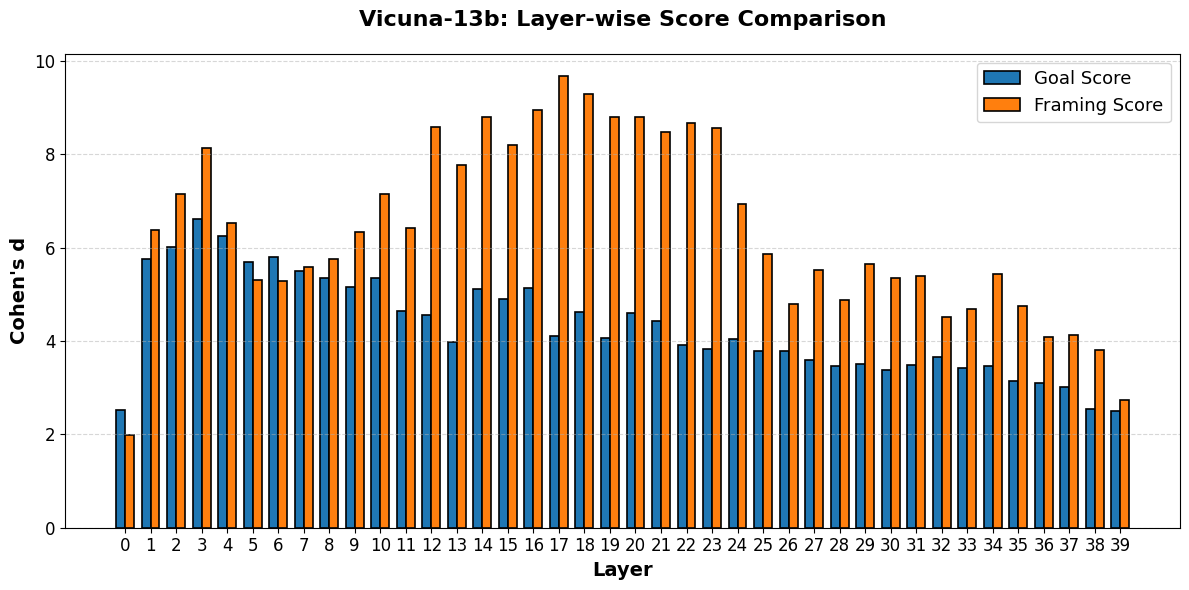

In [15]:
import matplotlib.pyplot as plt
import numpy as np

hf_to_common_model_name = {
    "meta-llama/Llama-2-7b-chat-hf": "Llama-2-7b",
    "meta-llama/Meta-Llama-3-8B-Instruct": "Llama-3-8b",
    "mistralai/Mistral-7B-v0.1": "Mistral-7b",
    "lmsys/vicuna-13b-v1.5": "Vicuna-13b",
    "lmsys/vicuna-7b-v1.5": "Vicuna-7b"
}

short_name = hf_to_common_model_name.get(cfg_out['model']['name'], cfg_out['model']['name'])

# Collect layers and delta values
layers = sorted(best_g.keys())
delta_g = [best_g[l]['score'] for l in layers]
delta_f = [best_f[l]['score'] for l in layers]

x = np.arange(len(layers))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, delta_g, width, label='Goal Score', color='#1f77b4', edgecolor='black', linewidth=1.2)
plt.bar(x + width/2, delta_f, width, label='Framing Score', color='#ff7f0e', edgecolor='black', linewidth=1.2)

plt.xlabel('Layer', fontsize=14, fontweight='bold')
plt.ylabel("Cohen's d", fontsize=14, fontweight='bold')
plt.title(f'{short_name}: Layer-wise Score Comparison', fontsize=16, fontweight='bold', pad=20)
plt.xticks(x, layers, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=13, frameon=True, loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

os.makedirs("./results/figures/critical_layer/", exist_ok=True)
# plt.savefig(f"./results/figures/critical_layer/critical_layer_{short_name}_dist.png", dpi=200)
plt.show()

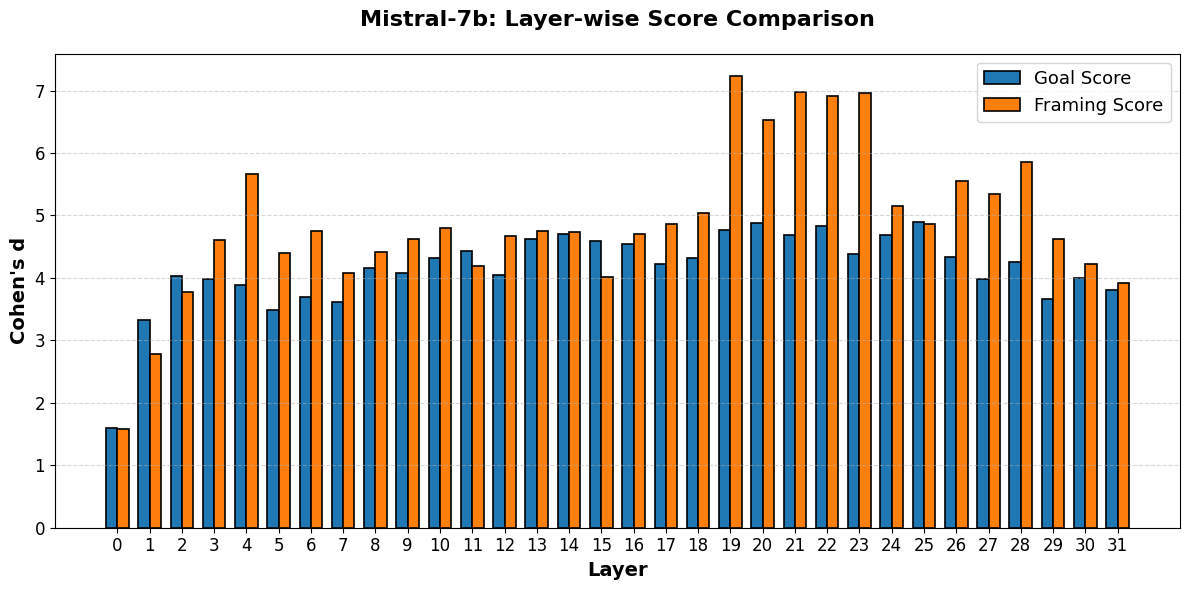

In [16]:
import matplotlib.pyplot as plt
import numpy as np

hf_to_common_model_name = {
    "meta-llama/Llama-2-7b-chat-hf": "Llama-2-7b",
    "meta-llama/Meta-Llama-3-8B-Instruct": "Llama-3-8b",
    "mistralai/Mistral-7B-v0.1": "Mistral-7b",
    "lmsys/vicuna-13b-v1.5": "Vicuna-13b",
    "lmsys/vicuna-7b-v1.5": "Vicuna-7b"
}

short_name = hf_to_common_model_name.get(cfg_out['model']['name'], cfg_out['model']['name'])

# Collect layers and delta values
layers = sorted(best_g.keys())
delta_g = [best_g[l]['score'] for l in layers]
delta_f = [best_f[l]['score'] for l in layers]

x = np.arange(len(layers))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, delta_g, width, label='Goal Score', color='#1f77b4', edgecolor='black', linewidth=1.2)
plt.bar(x + width/2, delta_f, width, label='Framing Score', color='#ff7f0e', edgecolor='black', linewidth=1.2)

plt.xlabel('Layer', fontsize=14, fontweight='bold')
plt.ylabel("Cohen's d", fontsize=14, fontweight='bold')
plt.title(f'{short_name}: Layer-wise Score Comparison', fontsize=16, fontweight='bold', pad=20)
plt.xticks(x, layers, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=13, frameon=True, loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

os.makedirs("./results/figures/critical_layer/", exist_ok=True)
plt.savefig(f"./results/figures/critical_layer/critical_layer_{short_name}_dist.png", dpi=200)
plt.show()

In [75]:
for l in best_f:
    print(f"\nDec Layer {l}:")
    print(f"G   |   enc layer: {best_g_cos[l]['encoder_l']}, Δ: {best_g_cos[l]['Δ']}")
    print(f"F   |   enc layer: {best_f_cos[l]['encoder_l']}, Δ: {best_f_cos[l]['Δ']}")


Dec Layer 0:
G   |   enc layer: 0, Δ: 0.56494140625
F   |   enc layer: 0, Δ: 1.38623046875

Dec Layer 1:
G   |   enc layer: 1, Δ: 0.695556640625
F   |   enc layer: 1, Δ: 1.39892578125

Dec Layer 2:
G   |   enc layer: 2, Δ: 0.760986328125
F   |   enc layer: 2, Δ: 1.34814453125

Dec Layer 3:
G   |   enc layer: 3, Δ: 0.645263671875
F   |   enc layer: 3, Δ: 1.3671875

Dec Layer 4:
G   |   enc layer: 4, Δ: 1.286376953125
F   |   enc layer: 4, Δ: 1.3671875

Dec Layer 5:
G   |   enc layer: 5, Δ: 0.964111328125
F   |   enc layer: 5, Δ: 1.36279296875

Dec Layer 6:
G   |   enc layer: 6, Δ: 0.8233642578125
F   |   enc layer: 6, Δ: 1.364990234375

Dec Layer 7:
G   |   enc layer: 7, Δ: 0.83837890625
F   |   enc layer: 7, Δ: 1.326171875

Dec Layer 8:
G   |   enc layer: 8, Δ: 0.79345703125
F   |   enc layer: 8, Δ: 1.35986328125

Dec Layer 9:
G   |   enc layer: 9, Δ: 0.87896728515625
F   |   enc layer: 9, Δ: 1.357666015625

Dec Layer 10:
G   |   enc layer: 10, Δ: 0.88372802734375
F   |   enc layer: 1

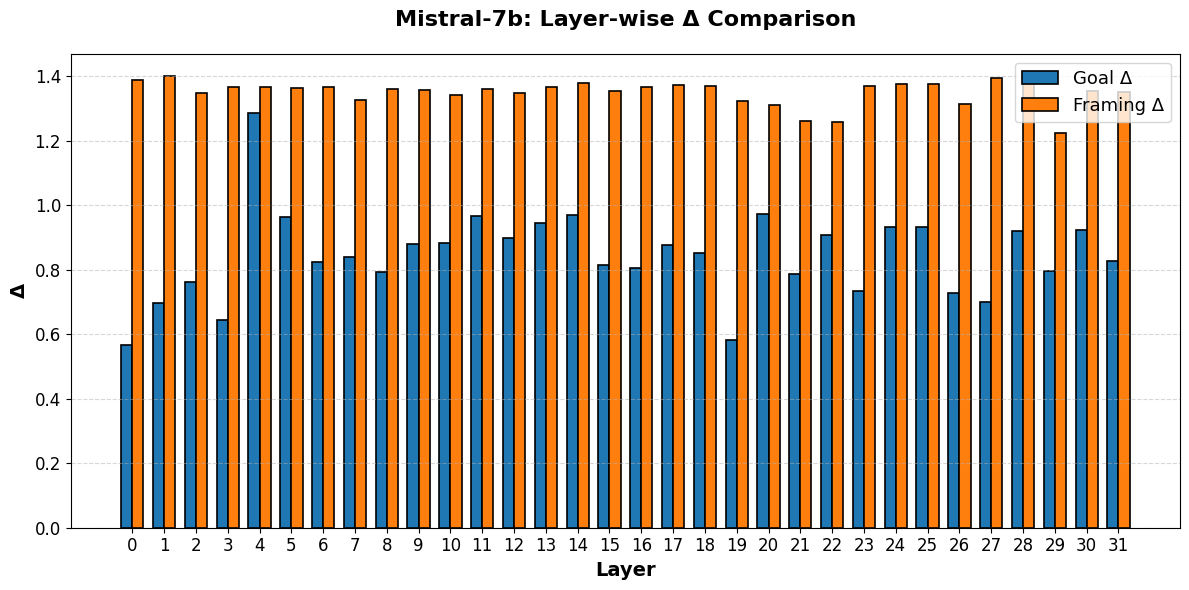

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Collect layers and delta values
layers = sorted(best_g_cos.keys())
delta_g = [best_g_cos[l]['Δ'] for l in layers]
delta_f = [best_f_cos[l]['Δ'] for l in layers]

x = np.arange(len(layers))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, delta_g, width, label='Goal Δ', color='#1f77b4', edgecolor='black', linewidth=1.2)
plt.bar(x + width/2, delta_f, width, label='Framing Δ', color='#ff7f0e', edgecolor='black', linewidth=1.2)

plt.xlabel('Layer', fontsize=14, fontweight='bold')
plt.ylabel('Δ', fontsize=14, fontweight='bold')
plt.title(f'{short_name}: Layer-wise Δ Comparison', fontsize=16, fontweight='bold', pad=20)
plt.xticks(x, layers, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=13, frameon=True, loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

os.makedirs("./results/figures/critical_layer/", exist_ok=True)
# plt.savefig(f"./results/figures/critical_layer/critical_layer_{short_name}_cos.png", dpi=200)
plt.show()

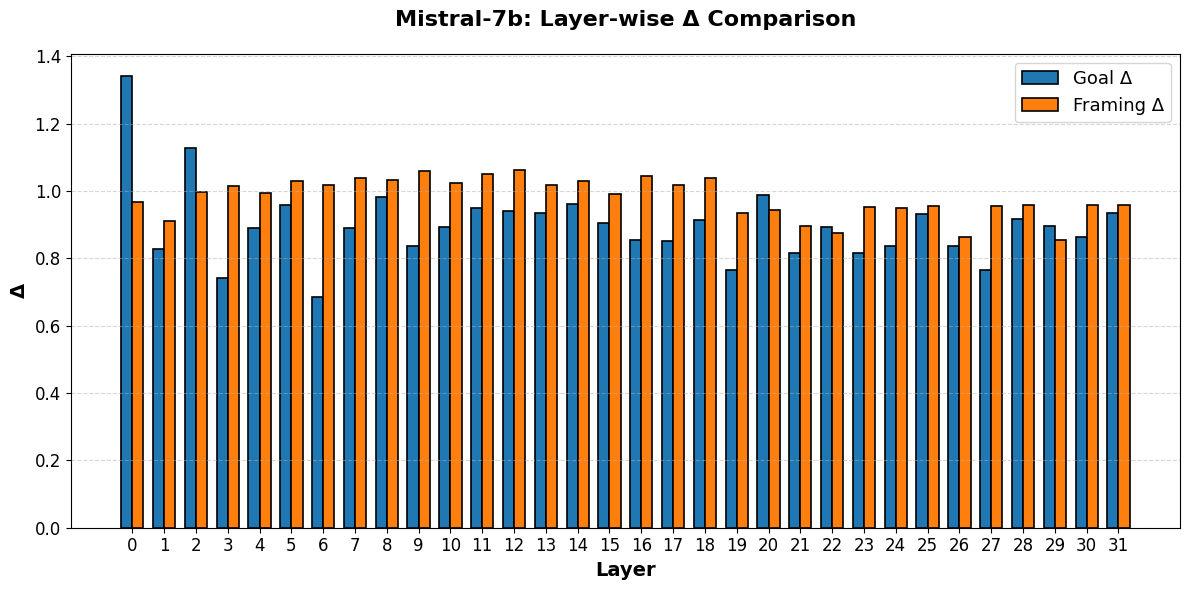

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Collect layers and delta values
layers = sorted(best_g_cos.keys())
delta_g = [best_g_cos[l]['Δ'] for l in layers]
delta_f = [best_f_cos[l]['Δ'] for l in layers]

x = np.arange(len(layers))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, delta_g, width, label='Goal Δ', color='#1f77b4', edgecolor='black', linewidth=1.2)
plt.bar(x + width/2, delta_f, width, label='Framing Δ', color='#ff7f0e', edgecolor='black', linewidth=1.2)

plt.xlabel('Layer', fontsize=14, fontweight='bold')
plt.ylabel('Δ', fontsize=14, fontweight='bold')
plt.title(f'{short_name}: Layer-wise Δ Comparison', fontsize=16, fontweight='bold', pad=20)
plt.xticks(x, layers, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=13, frameon=True, loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

os.makedirs("./results/figures/critical_layer/", exist_ok=True)
plt.savefig(f"./results/figures/critical_layer/critical_layer_{short_name}_cos.png", dpi=200)
plt.show()

### Load selected encoder and decomposer

In [16]:
best_g_tups = sorted(best_g.items(), key=lambda x: x[1]['score'], reverse=True)
best_f_tups = sorted(best_f.items(), key=lambda x: x[1]['score'], reverse=True)
num_layers = model_llm.config.num_hidden_layers

In [24]:
DETECT_VIA_FRAMING = True
USE_CRITICAL_LAYER = False

if DETECT_VIA_FRAMING:
    enc_layer = [l for l, _ in best_f_tups if l >= num_layers//2][0]
else:
    enc_layer = [l for l, _ in best_g_tups if l >= num_layers//2][0]

if not USE_CRITICAL_LAYER:
    enc_layer = max([l for l, _ in best_g_tups]) # last layer
dec_layer = enc_layer
enc_layer

39

In [25]:

# RUN_ID_dec = "20250719" # UNIQUE_ID
import re, glob, os

pattern = re.compile(r"decomposer_layer(\d+)_")
ckpt_by_layer = {}
# for p in glob.glob(f"./checkpoints/decomposer_simple/decomposer_layer*{RUN_ID_dec}*"):
for p in glob.glob(f"./checkpoints/decomposer_simple/vic13_decomposer_layer*{RUN_ID_dec}*"): # for vicuna 13b only
    m = pattern.search(os.path.basename(p))
    if m: ckpt_by_layer[int(m.group(1))] = p

# load LLM encoder
model_llm, tokenizer = load_model(ENC_LLM_NAME, device=device)
encoder = HFEncoder_notPooled(
    model=model_llm,
    tokenizer=tokenizer,
    device=device,
    layers=[enc_layer],
    layer_combine=config['model']['layer_combine'],
)

# load decomposer weights
ckpt = torch.load(f"{ckpt_by_layer[dec_layer]}/weights.pt", map_location=device)
enc_dim_ckpt = ckpt["Wg.0.weight"].shape[1]

decomposer = NonlinearDecomposer(
    enc_dim    = enc_dim_ckpt,
    d_g        = config['d_g'],
    d_f        = config['d_f'],
    hidden_dim = config.get('hidden_dim', 1024),
    dropout    = config.get('dropout', 0.1),
).to(device)
# decomposer = NonlinearDecomposer_tiny(
#     enc_dim    = enc_dim_ckpt,
# ).to(device)

decomposer.load_state_dict(ckpt)
decomposer.half().eval()
decomposer.eval()

INFO:utils.model_utils:Loading model: lmsys/vicuna-13b-v1.5 on cuda
/mnt/home/amir/jupyter-env/lib/python3.11/site-packages/transformers/models/auto/tokenization_auto.py:902: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/mnt/home/amir/jupyter-env/lib/python3.11/site-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


NonlinearDecomposer(
  (Wg): Sequential(
    (0): Linear(in_features=5120, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (Wf): Sequential(
    (0): Linear(in_features=5120, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (recon): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=5120, bias=True)
  )
)

## Build spaces

In [26]:
DETECT_VIA_FRAMING = True

# if DETECT_VIA_FRAMING:
#     enc_layer = [l for l, _ in best_f_tups if l > num_layers//2][0]
# else:
#     enc_layer = [l for l, _ in best_g_tups if l > num_layers//2][0]
# dec_layer = enc_layer

In [27]:
# ==== Cell: [Build Framing Vectors] ====

@torch.no_grad()
def framing_vecs(texts: list[str], batch_size: int = 32) -> torch.Tensor:
    all_v = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        rep   = encoder(batch)               # (B, D_enc) or (B, T, D_enc)
        _, v_f, _ = decomposer(rep)          # framing component
        if v_f.dim() == 3:                   # token-wise
            v_f = v_f.mean(dim=1)
        all_v.append(v_f.cpu())
    return torch.cat(all_v, dim=0)

@torch.no_grad()
def goal_vecs(texts: list[str], batch_size: int = 32) -> torch.Tensor:
    all_v = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        rep   = encoder(batch)               # (B, D_enc) or (B, T, D_enc)
        v_g, _, _ = decomposer(rep)          # framing component
        if v_g.dim() == 3:                   # token-wise
            v_g = v_g.mean(dim=1)
        all_v.append(v_g.cpu())
    return torch.cat(all_v, dim=0)


if DETECT_VIA_FRAMING:
    v_ben_ID  = framing_vecs(ben_ID)
    v_jb_ID   = framing_vecs(jb_ID)
    v_ben_OOD = framing_vecs(ben_OOD)
    v_jb_OOD  = framing_vecs(jb_OOD)
    logger.info("Built framing vectors for all splits.")
else:
    v_ben_ID  = goal_vecs(ben_ID)
    v_jb_ID   = goal_vecs(jb_ID)
    v_ben_OOD = goal_vecs(ben_OOD)
    v_jb_OOD  = goal_vecs(jb_OOD)
    logger.info("Built goal vectors for all splits.")


INFO:__main__:Built framing vectors for all splits.


### Whiten and PCA

In [30]:
from sklearn.covariance import LedoitWolf#, EmpiricalCovariance



def fit_whiten_pca(X: np.ndarray, alpha: float = 0.9):
    mu   = X.mean(axis=0, keepdims=True)
    Xc   = X - mu
    cov  = np.cov(Xc, rowvar=False) + 1e-5*np.eye(X.shape[1])
    # lwcov = LedoitWolf()
    # cov = lwcov.fit(X)
    vals, vecs = np.linalg.eigh(cov)
    W    = vecs @ np.diag(vals**-0.5) @ vecs.T
    Z    = Xc @ W.T

    pca  = PCA(whiten=False).fit(Z)
    cum  = np.cumsum(pca.explained_variance_ratio_)
    r    = int(np.searchsorted(cum, alpha)) + 1
    P    = pca.components_[:r].T

    return {"mu": mu, "W": W, "P": P}

# fit detector on benign-ID
# detector = fit_whiten_pca(v_ben_ID.numpy(), alpha=0.9)
# alphas = [.5,.6,0.7,0.8,0.9,.95,.99]
alphas = [0.7,0.9]
detectors = {a: fit_whiten_pca(v_ben_ID.numpy(), alpha=a) for a in alphas}

# pickle.dump(detector, open("checkpoints/nsp_detector.pkl","wb"))

# precompute benign centroid
def residual_vec(V: np.ndarray, det):
    z    = (V - det["mu"]) @ det["W"].T
    proj = det["P"] @ (det["P"].T @ z.T)
    return z - proj.T

R_ben_IDs = {a: residual_vec(v_ben_ID.numpy(), detectors[a])
             for a in detectors}
R_ben_IDs = {a: R_ben_IDs[a] / (np.linalg.norm(R_ben_IDs[a], axis=1, keepdims=True) + 1e-9)
             for a in R_ben_IDs}
centroids = {a: R_ben_IDs[a].mean(axis=0, keepdims=True)
             for a in R_ben_IDs}


### With L2

#### With Val Set 

In [29]:
# ==== Cell: [Detection – χ²-based L2 NSP (with validation split)] ====

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 1) Split benign ID into train / val
ben_ID_train, ben_ID_val = train_test_split(v_ben_ID, test_size=0.05, random_state=42)
jb_ID_train,  jb_ID_val  = train_test_split(v_jb_ID,  test_size=0.05, random_state=42)

# 2) Fit detector on train split
# detector_l2_val = fit_whiten_pca(ben_ID_train.numpy(), alpha=0.9)
# alphas = [0.7,.8, .85, 0.9, .95]
alphas = [.8, 0.7, 0.9]
detectors_l2_val = {a: fit_whiten_pca(ben_ID_train.numpy(), alpha=a) for a in alphas}


# 3) χ² threshold (squared-L2 residual)
chis_df_val = {a: ben_ID_train.shape[1] - detectors_l2_val[a]["P"].shape[1] for a in alphas}
taus_l2_val = {a: chi2.ppf(0.95, df=chis_df_val[a]) ** 0.5 for a in alphas}
for a in alphas:    
    print(f"χ²-based τ (with val, alpha={a}) = {taus_l2_val[a]:.4f}")

# 4) Scoring & evaluation
def nsp_score_l2(V: np.ndarray, det) -> np.ndarray:
    res = residual_vec(V, det)
    return np.linalg.norm(res, axis=1)

def eval_l2_with_val(v_ben, v_jb, name):
    y_true = np.concatenate([np.zeros(len(v_ben)), np.ones(len(v_jb))])
    scores = {a: np.concatenate([
        nsp_score_l2(v_ben.numpy(), detectors_l2_val[a]),
        nsp_score_l2(v_jb.numpy(), detectors_l2_val[a]),
    ]) for a in detectors_l2_val}
    y_pred = {a: (scores[a] > taus_l2_val[a]).astype(int) for a in alphas}

    au   = {a: roc_auc_score(y_true, scores[a]) for a in alphas}
    prec_rec_f1_ = {a: precision_recall_fscore_support(
        y_true, y_pred[a], average="binary", pos_label=1, zero_division=0
    ) for a in alphas}
    accs = {a: accuracy_score(y_true, y_pred[a]) for a in alphas}
    tprs = {a: y_pred[a][len(v_ben):].mean() for a in alphas}
    fprs = {a: y_pred[a][:len(v_ben)].mean() for a in alphas}
    fnrs = {a: (1 - y_pred[a][len(v_ben):]).mean() for a in alphas}
    tnrs = {a: (1 - y_pred[a][:len(v_ben)]).mean() for a in alphas}
    for a in alphas:
        print(f"alpha={a:>2} , {name:>6} | Acc {accs[a]:.3f} F1 {prec_rec_f1_[a][2]:.3f} AUROC {au[a]:.3f} Prec {prec_rec_f1_[a][0]:.3f}  Rec {prec_rec_f1_[a][1]:.3f} TPR {tprs[a]:.3f} FPR {fprs[a]:.3f} TNR {tnrs[a]:.3f} FNR {fnrs[a]:.3f}")

# Eval on held-out ID val and full OOD
eval_l2_with_val(ben_ID_val,  jb_ID_val,  "ID-val")
eval_l2_with_val(v_ben_OOD,  v_jb_OOD,  "OOD")


χ²-based τ (with val, alpha=0.8) = 14.0379
χ²-based τ (with val, alpha=0.7) = 15.7152
χ²-based τ (with val, alpha=0.9) = 11.8288
alpha=0.8 , ID-val | Acc 0.779 F1 0.753 AUROC 0.848 Prec 0.853  Rec 0.674 TPR 0.674 FPR 0.116 TNR 0.884 FNR 0.326
alpha=0.7 , ID-val | Acc 0.783 F1 0.770 AUROC 0.859 Prec 0.817  Rec 0.729 TPR 0.729 FPR 0.163 TNR 0.837 FNR 0.271
alpha=0.9 , ID-val | Acc 0.775 F1 0.721 AUROC 0.855 Prec 0.949  Rec 0.581 TPR 0.581 FPR 0.031 TNR 0.969 FNR 0.419
alpha=0.8 ,    OOD | Acc 0.780 F1 0.772 AUROC 0.860 Prec 0.823  Rec 0.726 TPR 0.726 FPR 0.164 TNR 0.836 FNR 0.274
alpha=0.7 ,    OOD | Acc 0.753 F1 0.765 AUROC 0.862 Prec 0.746  Rec 0.784 TPR 0.784 FPR 0.280 TNR 0.720 FNR 0.216
alpha=0.9 ,    OOD | Acc 0.786 F1 0.749 AUROC 0.859 Prec 0.938  Rec 0.623 TPR 0.623 FPR 0.043 TNR 0.957 FNR 0.377


#### Without Val Set

In [55]:
# ==== Cell: [Detection – χ²-based L2 NSP (without validation split)] ====

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 2) Fit detector on train split
# detector_l2 = fit_whiten_pca(v_ben_ID.numpy(), alpha=0.9)
alphas = [.5, .6,0.7,0.9]
detectors_l2 = {a: fit_whiten_pca(v_ben_ID.numpy(), alpha=a) for a in alphas}
# 3) χ² threshold (squared-L2 residual)
chis_df = {a: v_ben_ID.shape[1] - detectors_l2[a]["P"].shape[1] for a in alphas}
taus_l2 = {a: chi2.ppf(0.95, df=chis_df[a]) ** 0.5 for a in alphas}
for a in alphas:
    print(f"χ²-based τ (without val, alpha={a}) = {taus_l2[a]:.4f}")

# 4) Scoring & evaluation
def nsp_score_l2(V: np.ndarray, det) -> np.ndarray:
    res = residual_vec(V, det)
    return np.linalg.norm(res, axis=1)

def eval_l2_without_val(v_ben, v_jb, name):
    y_true = np.concatenate([np.zeros(len(v_ben)), np.ones(len(v_jb))])
    scores = {a: np.concatenate([
        nsp_score_l2(v_ben.numpy(), detectors_l2[a]),
        nsp_score_l2(v_jb.numpy(), detectors_l2[a]),
    ]) for a in detectors_l2}
    y_pred = {a: (scores[a] > taus_l2[a]).astype(int) for a in alphas}

    au   = {a: roc_auc_score(y_true, scores[a]) for a in alphas}
    prec_rec_f1_ = {a: precision_recall_fscore_support(
        y_true, y_pred[a], average="binary", pos_label=1, zero_division=0
    ) for a in alphas}
    accs = {a: accuracy_score(y_true, y_pred[a]) for a in alphas}
    tprs = {a: y_pred[a][len(v_ben):].mean() for a in alphas}
    fprs = {a: y_pred[a][:len(v_ben)].mean() for a in alphas}
    fnrs = {a: (1 - y_pred[a][len(v_ben):]).mean() for a in alphas}
    tnrs = {a: (1 - y_pred[a][:len(v_ben)]).mean() for a in alphas}
    for a in alphas:
        print(f"alpha={a:>2} , {name:>6} | Acc {accs[a]:.3f} F1 {prec_rec_f1_[a][2]:.3f} AUROC {au[a]:.3f} Prec {prec_rec_f1_[a][0]:.3f}  Rec {prec_rec_f1_[a][1]:.3f} TPR {tprs[a]:.3f} FPR {fprs[a]:.3f} TNR {tnrs[a]:.3f} FNR {fnrs[a]:.3f}")
 
# Eval on held-out ID val and full OOD
eval_l2_without_val(v_ben_ID,  v_jb_ID,  "ID")
eval_l2_without_val(v_ben_OOD,  v_jb_OOD,  "OOD")


χ²-based τ (without val, alpha=0.5) = 18.3027
χ²-based τ (without val, alpha=0.6) = 16.9671
χ²-based τ (without val, alpha=0.7) = 15.4727
χ²-based τ (without val, alpha=0.9) = 11.5437
alpha=0.5 ,     ID | Acc 0.952 F1 0.950 AUROC 0.987 Prec 0.980  Rec 0.921 TPR 0.921 FPR 0.018 TNR 0.982 FNR 0.079
alpha=0.6 ,     ID | Acc 0.956 F1 0.955 AUROC 0.991 Prec 0.995  Rec 0.917 TPR 0.917 FPR 0.005 TNR 0.995 FNR 0.083
alpha=0.7 ,     ID | Acc 0.947 F1 0.944 AUROC 0.992 Prec 0.999  Rec 0.894 TPR 0.894 FPR 0.001 TNR 0.999 FNR 0.106
alpha=0.9 ,     ID | Acc 0.866 F1 0.845 AUROC 0.994 Prec 1.000  Rec 0.731 TPR 0.731 FPR 0.000 TNR 1.000 FNR 0.269
alpha=0.5 ,    OOD | Acc 0.510 F1 0.655 AUROC 0.852 Prec 0.487  Rec 1.000 TPR 1.000 FPR 0.917 TNR 0.083 FNR 0.000
alpha=0.6 ,    OOD | Acc 0.518 F1 0.659 AUROC 0.849 Prec 0.491  Rec 1.000 TPR 1.000 FPR 0.901 TNR 0.099 FNR 0.000
alpha=0.7 ,    OOD | Acc 0.524 F1 0.660 AUROC 0.851 Prec 0.494  Rec 0.994 TPR 0.994 FPR 0.885 TNR 0.115 FNR 0.006
alpha=0.9 ,    OOD